In [1]:
!pip install tensorflow


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from pandas import set_option
from pandas import DataFrame

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from pickle import dump

In [3]:
# Load the data
# Assuming you have downloaded and extracted the Rossmann dataset
data = pd.read_csv(r"C:\Users\Sudeep\Downloads\rossmann-store-sales\train.csv",low_memory=False)
store = pd.read_csv(r"C:\Users\Sudeep\Downloads\rossmann-store-sales\store.csv",dtype={'column_name': str})

# Merge datasets
data = data.merge(store, on='Store', how='left')

# Filter for open stores, drop rows with missing Sales data
data = data[(data['Open'] == 1) & (~data['Sales'].isnull())]

In [4]:
data.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [5]:
data.head(1000)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,998,5,2015-07-31,6533,651,1,1,0,1,a,a,780.0,9.0,2005.0,1,5.0,2013.0,"Feb,May,Aug,Nov"
998,999,5,2015-07-31,11274,749,1,1,0,1,d,c,15140.0,2.0,2002.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
999,1000,5,2015-07-31,8935,749,1,1,0,0,a,c,2230.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
1000,1001,5,2015-07-31,7724,764,1,1,0,1,c,a,19640.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


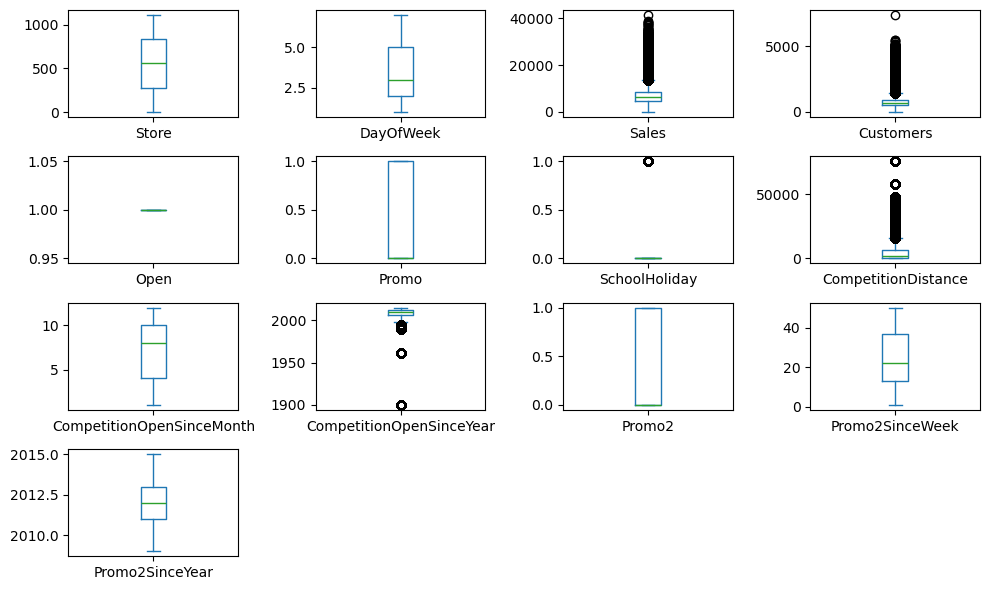

In [6]:
# Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)
plt.show()

                              Store  DayOfWeek     Sales  Customers  Open  \
Store                      1.000000   0.000346  0.007710   0.033977   NaN   
DayOfWeek                  0.000346   1.000000 -0.178736  -0.097266   NaN   
Sales                      0.007710  -0.178736  1.000000   0.823597   NaN   
Customers                  0.033977  -0.097266  0.823597   1.000000   NaN   
Open                            NaN        NaN       NaN        NaN   NaN   
Promo                     -0.000012  -0.289265  0.368145   0.182846   NaN   
SchoolHoliday              0.000512  -0.139315  0.038617   0.024902   NaN   
CompetitionDistance       -0.027049   0.005535 -0.036396  -0.148506   NaN   
CompetitionOpenSinceMonth -0.051089   0.000379 -0.043489  -0.044965   NaN   
CompetitionOpenSinceYear  -0.005028   0.001273  0.016101   0.010175   NaN   
Promo2                     0.007736  -0.003241 -0.127596  -0.202232   NaN   
Promo2SinceWeek            0.010681  -0.000599  0.095311   0.061682   NaN   

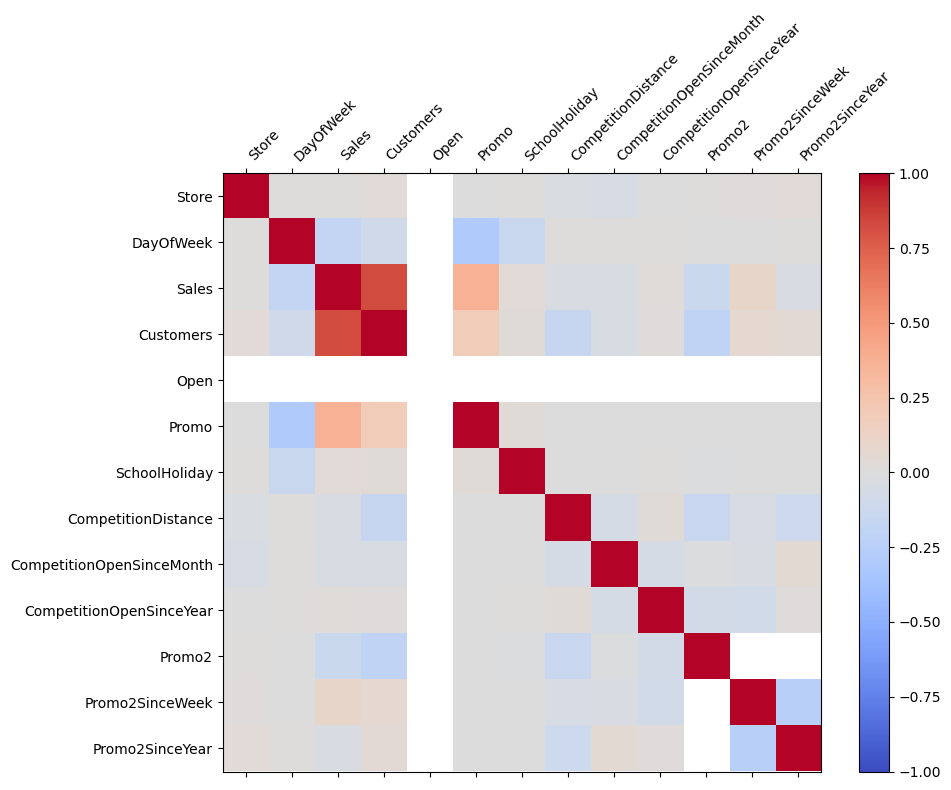

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Filter numeric columns only
numeric_data = data.select_dtypes(include=[np.number])

# Calculate and print the correlation matrix
correlation_matrix = numeric_data.corr(method='pearson')
print(correlation_matrix)

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_matrix, vmin=-1, vmax=1, cmap='coolwarm')
fig.colorbar(cax)

# Customize tick marks
names = list(numeric_data.columns)
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=45, ha='left')
ax.set_yticklabels(names)
plt.show()


In [8]:
# Data Cleaning: Extract Date feature into subcategories
data['Date'] = pd.to_datetime(data['Date'])
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.isocalendar().week  # Use isocalendar().week for week number
data["Day"] = data["Date"].dt.day

# Create two new features representing weekend and promotion months
data["weekend"] = np.where(data["DayOfWeek"].isin([6, 7]), "Weekend", "Weekday")
data["promotion"] = np.where(data["Month"].isin([7, 8, 11, 12]), "Pro_Month", "Reg_Month")

# Example target assignment
y_temp = data['Sales']


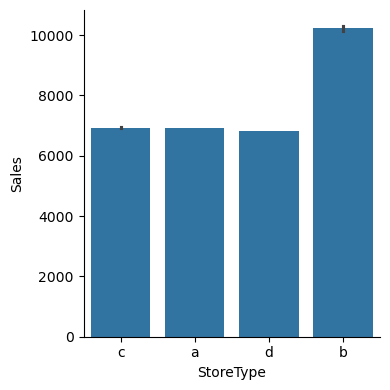

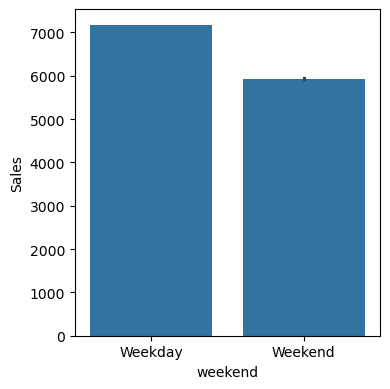

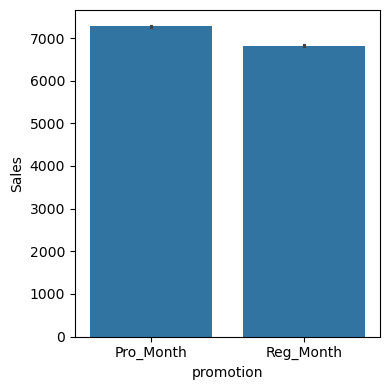

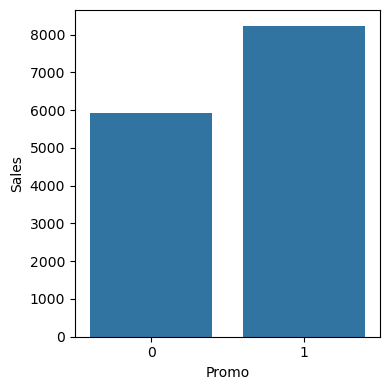

In [9]:
import seaborn as sn

# Visualize Sales vs. store type 
fig1, ax1 = plt.subplots(figsize=(4,4))
sn.barplot(x=data['StoreType'], y=y_temp, data=data, ax=ax1)

# Visualize Sales vs. weekend
fig2, ax2 = plt.subplots(figsize=(4, 4))
sn.barplot(x=data['weekend'], y=y_temp, data=data, ax=ax2)

# Visualize Sales vs. promotion months 
fig3, ax3 = plt.subplots(figsize=(4, 4))
sn.barplot(x=data['promotion'], y=y_temp, data=data, ax=ax3)

# Visualize Sales vs. Promo 
fig4, ax4 = plt.subplots(figsize=(4,4))
sn.barplot(x=data['Promo'], y=y_temp, data=data, ax=ax4)

sn.despine(fig1, fig2, fig3, fig4)

In [10]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Sales']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

C:\Users\Sudeep\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Sudeep\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [11]:
# summarize the number of unique values in each column
print(data.nunique())

# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Store                         1094
DayOfWeek                        7
Date                           942
Sales                        21734
Customers                     4086
Open                             1
Promo                            2
StateHoliday                     4
SchoolHoliday                    2
StoreType                        4
Assortment                       3
CompetitionDistance            641
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        20
Promo2                           2
Promo2SinceWeek                 24
Promo2SinceYear                  7
PromoInterval                    3
Year                             3
Month                           12
Week                            52
Day                             31
weekend                          2
promotion                        2
dtype: int64
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Cus

In [12]:
# Impute missing values with 'mode' values in this important variable (CompetitionDistance)
data["CompetitionDistance"]=data["CompetitionDistance"].fillna(data["CompetitionDistance"].mode()[0])

In [29]:
# Convert strings into categorial classes
mapping1 = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
data['StoreType'] = data['StoreType'].replace(mapping1)

mapping2 = {'a': 1, 'b': 2, 'c': 3}
data['Assortment'] = data['Assortment'].replace(mapping2)

mapping3 = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
data['StateHoliday'] = data['StateHoliday'].replace(mapping3)

# Convert strings into categorial classes
data = pd.get_dummies(data = data, columns = ["weekend", "promotion"])
print(data.shape)

(844392, 26)


In [31]:
print(data.columns)  

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Week', 'Day',
       'weekend_Weekday', 'weekend_Weekend', 'promotion_Pro_Month',
       'promotion_Reg_Month'],
      dtype='object')


In [33]:
# One hot encoding these categorial features
ohe = OneHotEncoder(categories='auto')
ohe.fit_transform(data[['StoreType', 'Assortment', 'StateHoliday']]).toarray()
print(data.shape)

(844392, 26)


In [35]:
# b) Split the data into training, test, and validation sets

train = data[:int(len(data) * 0.7)]
test = data[int(len(data) * 0.7):int(len(data) * 0.9)]
validation = data[int(len(data) * 0.9):]
print(train.shape, test.shape, validation.shape)

X_train = train.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
X_test = test.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
X_val = validation.drop(columns=['Sales', 'Store', 'Date', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis = 1)
y_val = validation['Sales']

(591074, 26) (168878, 26) (84440, 26)


In [37]:
y_train_ori = train['Sales']
y_test_ori = test['Sales']

# There are a number of methods to make data stationary in time: difference, log/squared root transform, 
# decomposition, and ARIMA. Here I use the squared root transformation considering broad range of data.
train.loc[:, 'Sales_sqrt'] = np.sqrt(y_train_ori)
test.loc[:, 'Sales_sqrt']  = np.sqrt(y_test_ori)

# Now we can use Sales_sqrt as a new target for training and validation
y_train = train['Sales_sqrt']
y_test = test['Sales_sqrt']

C:\Users\Sudeep\AppData\Local\Temp\ipykernel_33700\3720670071.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, 'Sales_sqrt'] = np.sqrt(y_train_ori)
C:\Users\Sudeep\AppData\Local\Temp\ipykernel_33700\3720670071.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Sales_sqrt']  = np.sqrt(y_test_ori)


In [39]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)
X_val = DataFrame(X_val)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(591074, 18) (168878, 18)
(591074,) (168878,)


In [41]:
# Define baseline mean_absolute_error of y_test and y in the data set
y_mean = np.mean(y_temp)
y_mean = np.array([y_mean]*len(y_test))
mae_ori = mean_absolute_error(y_test**2, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  2235.6156243730943


In [43]:
# Function to convert an array into a input tensor for LSTM. Note that lookback window determines 
# how far back in time (number of previous time steps) the model considers when making a prediction. 

def create_tensor(data, lookback):
    X = []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
    return np.array(X)

In [45]:
# Convert the training, testing, and validation arrays into input tensors [samples, timesteps, features]
# for LSTM model. Here I select 7 days lookback to capture sales data changes in weekly basis.

lookback = 7
X_train = create_tensor(X_train, lookback)
X_test = create_tensor(X_test, lookback)
X_val = create_tensor(X_val, lookback)
y_train = y_train[lookback:]
y_test = y_test[lookback:]
y_val = y_val[lookback:]

In [46]:
# build the LSTM model
# This kind of neural network model is susceptible to overfitting, so incorporating BatchNormalization
# and Dropout layers can aid in stabilizing and enhancing the model's performance.

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization()),
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(BatchNormalization()),
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

C:\Users\Sudeep\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
# Define a callback for early stopping if the validation loss does not improve for 20 consecutive 
# epochs (patience=20).
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [48]:
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)


Epoch 1/50
4618/4618 - 86s - 19ms/step - loss: 4.2404 - val_loss: 0.0487
Epoch 2/50
4618/4618 - 89s - 19ms/step - loss: 0.0457 - val_loss: 0.0371
Epoch 3/50
4618/4618 - 87s - 19ms/step - loss: 0.0388 - val_loss: 0.0339
Epoch 4/50
4618/4618 - 82s - 18ms/step - loss: 0.0333 - val_loss: 0.0304
Epoch 5/50
4618/4618 - 88s - 19ms/step - loss: 0.0240 - val_loss: 0.0172
Epoch 6/50
4618/4618 - 95s - 20ms/step - loss: 0.0182 - val_loss: 0.0141
Epoch 7/50
4618/4618 - 96s - 21ms/step - loss: 0.0154 - val_loss: 0.0115
Epoch 8/50
4618/4618 - 131s - 28ms/step - loss: 0.0136 - val_loss: 0.0113
Epoch 9/50
4618/4618 - 89s - 19ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 10/50
4618/4618 - 87s - 19ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 11/50
4618/4618 - 153s - 33ms/step - loss: 0.0114 - val_loss: 0.0144
Epoch 12/50
4618/4618 - 133s - 29ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 13/50
4618/4618 - 133s - 29ms/step - loss: 0.0107 - val_loss: 0.0116
Epoch 14/50
4618/4618 - 88s - 19ms/step - l

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_predictions_sales(model, X, y, start=0, end=100):
    # Generate predictions from the model
    predictions = model.predict(X)
    
    # Convert y to a numpy array and flatten
    actuals = np.array(y).flatten() ** 2  # Square to revert from square root transformation
    predictions = predictions.flatten() ** 2
    
    # Create a DataFrame to store predictions and actuals
    df = pd.DataFrame(data={
        'Sales Predictions': predictions,
        'Sales Actuals': actuals
    })
    
    # Plot the predictions and actuals
    plt.figure(figsize=(12, 6))
    plt.plot(df['Sales Predictions'][start:end], label="Predicted Sales", color="red", linestyle="--")
    plt.plot(df['Sales Actuals'][start:end], label="Actual Sales", color="blue", linestyle="-")
    plt.xlabel("Time")
    plt.ylabel("Sales")
    plt.title("Sales Predictions vs Actuals")
    plt.legend()
    plt.show()
    
    # Return the DataFrame containing the predictions and actuals for the specified range
    return df[start:end]


5278/5278 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step


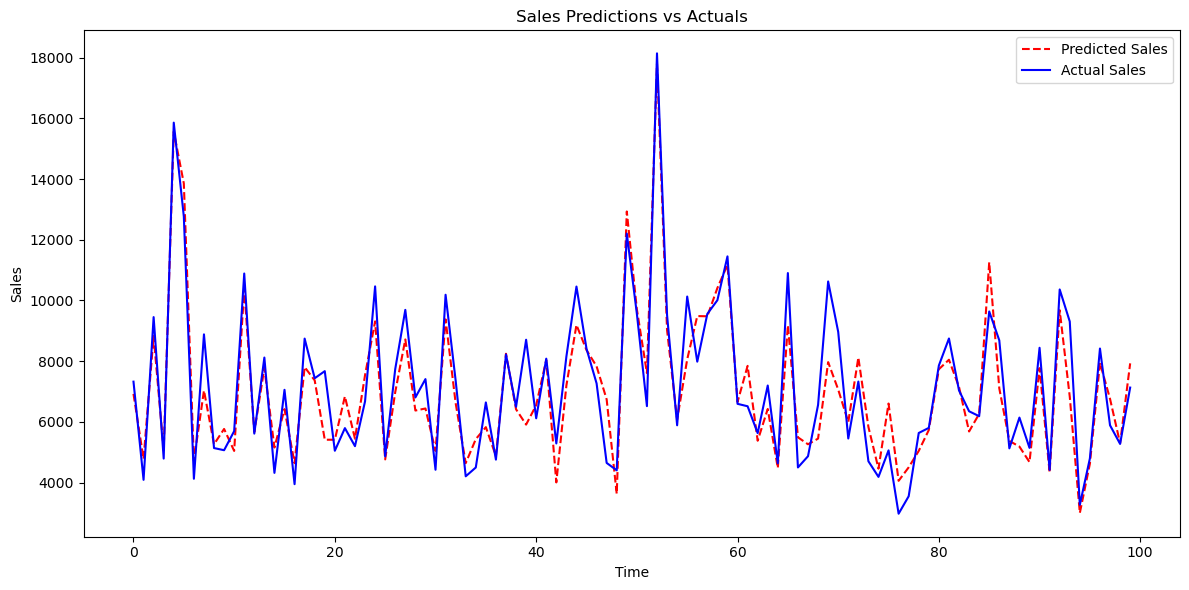

,Sales Predictions,Sales Actuals
0,6922.435059,7326.0
1,4777.191895,4091.0
2,8830.404297,9453.0
3,5061.807129,4791.0
4,15565.410156,15860.0
...,...,...
95,4624.628906,4797.0
96,7945.814453,8417.0
97,6758.410156,5888.0
98,5294.212402,5275.0


In [50]:
plot_predictions_sales(model, X_test, y_test, start=0, end=100)

In [51]:
# Save the model in the new Keras format
model.save('sales_prediction_model5.keras')
